**Nome:** Riccardo <br>
**Cognome:** Confalonieri<br>
**Numero matricola:** 830404<br>
**E-mail:** r.confalonieri5@campus.unimib.it<br>
**A.A.** 2021-2022<br>

# **Digital Signal and Image Management - Assignment 3**<br/>
**Master's Degree in Data Science (A.Y. 2021/2022)**<br/>
**University of Milano - Bicocca**<br/>

Simone Bianco, Marco Buzzelli

## Descrizione
<p align = 'justify'>
Creare uno script che permetta di realizzare lo stitching di due immagini utilizzando i keypoints estratti con SIFT. 
<p/>

## Import delle librerie

In [ ]:
# carico l'ultima versione di opencv disponibile per usare SIFT
!pip install opencv_contrib_python==3.4.2.17 --force-reinstall

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
# Mount GDrive
from google.colab import drive

## Loading images
Carico e visualizzo le prime due immagini di cui voglio eseguire lo stitching.

In [ ]:
# Link Google Drive account
drive.mount('/content/gdrive')
path = '/content/gdrive/MyDrive/Colab Notebooks/DigitalSignal/Assignment/Assignment3/Dati/'

Mounted at /content/gdrive


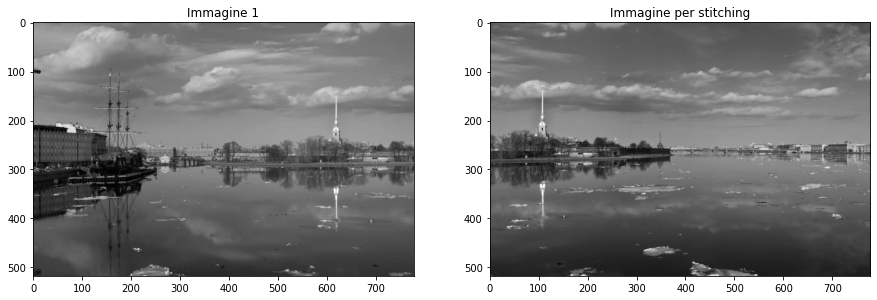

In [ ]:
# Caricamento immagini
img1 = cv.imread(path + 'boat1.jpg',0)
img2 = cv.imread(path + 'boat3.jpg',0)

# visualizzo le due immagini affiancate
fig = plt.figure(figsize=[15,5])
fig.add_subplot(1,2,1)
plt.imshow(img1, cmap='gray')
plt.title('Immagine 1')

fig.add_subplot(1,2,2)
plt.imshow(img2, cmap='gray')
plt.title('Immagine per stitching')
plt.show()

<p align = 'justify'>
Dalla visualizzazione si vede come la sovrapposizione sia soprattutto nell'intorno della "torre", che è presente in entrambe le immagini. Inoltre sembra che la seconda immagine sia leggermente più scura della prima.
</p>

In [ ]:
print("Dimensione della prima immagine:", img1.shape)
print("Dimensione della seconda immagine:", img2.shape)

Dimensione della prima immagine: (518, 778)
Dimensione della seconda immagine: (518, 778)


## Keypoint detection and description
Utilizzando SIFT estraggo i keypoint e le feature da entrambe le immagini.

In [ ]:
# istanzio SIFT
sift = cv.xfeatures2d.SIFT_create()

# estraggo i keypoint dalla prima immagine
kps1, features1 = sift.detectAndCompute(img1, None)
# estraggo i keypoint dalla seconda immagine
kps2, features2 = sift.detectAndCompute(img2, None)

In [ ]:
print("Numero di keypoint trovati per la prima immagine:", len(kps1))
print("Numero di keypoint trovati per la seconda immagine:", len(kps2))
print("Numero di descrittori per ogni keypoint:", features1.shape[1])

Numero di keypoint trovati per la prima immagine: 1193
Numero di keypoint trovati per la seconda immagine: 850
Numero di descrittori per ogni keypoint: 128


<p align='justify'>
Nonostante le due immagini abbiano la stessa dimensione sono stati trovati più keypoint per la prima immagine.
</p>

### Keypoint visualization
<p align='justify'>
Visualizzo sulle immagini i keypoint trovati rappresentando anche l'importanza e l'orientamento di ogni keypoint.
</p>

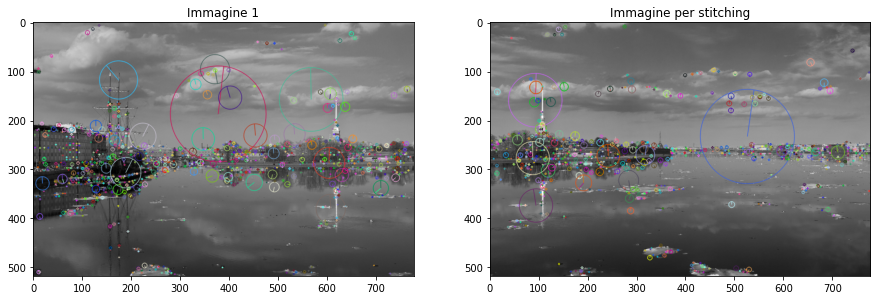

In [ ]:
# ottengo l'immagine con i keypoints
# con il flag visualizzo anche l'orientamento e l'importanza dei keypoint
img1_kps = cv.drawKeypoints(img1, kps1, None, 
                            flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kps = cv.drawKeypoints(img2, kps2, None, 
                            flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# visualizzo le due immagini affiancate con i keypoint
fig = plt.figure(figsize=[15,5])
fig.add_subplot(1,2,1)
plt.imshow(img1_kps, cmap='gray')
plt.title('Immagine 1')

fig.add_subplot(1,2,2)
plt.imshow(img2_kps, cmap='gray')
plt.title('Immagine per stitching')
plt.show()

<p align='justify'>
Sono stati trovati diversi keypoint, da questa prima visualizzazione però si nota che il keypoint più importante per la prima immagine e per la seconda immagine non potranno essere utilizzati per lo stitching per via della loro posizione
</p>

## Keypoint matching
<p align='justify'>
Matcho i keypoint e le feature trovate sulle due immagini in modo da poter poi effettuare lo stitching basandomi su di essi. Per il matching utilizzo un approccio brute-force. <br>
In particolare i punti di matching saranno i punti di sovrapposizione delle due immagini.
</p>

In [ ]:
"""
  inizializzo il matcher, crossCheck effettua il controllo in entrambe le direzioni
  Quindi per ogni keypoint dell'immagine base:
    1. cerca il keypoint più simile nell'immagine target
    2. Usa il keypoint target trovato per cercare il più simile nell'immagine base
    3. Se il keypoint più simile nell'immagine base è lo stesso di partenza allora è un match
"""
bf = cv.BFMatcher(crossCheck=True)

# eseguo il matching
matches = bf.match(features1, features2)

In [ ]:
# visualizzo alcune informazioni utili
print('Numero di matches trovati:', len(matches))

Numero di matches trovati: 535


<p align='justify'>
In partenza avevo $850$ keypoint (valore più basso dei keypoint trovati per l'immagine 2), sono riuscito a matcharne $535$. <br>
Delle informazioni dei match la <i>distance</i> ci dice quanto sono simili (distanti) le features dei due descrittori, sfrutto questa informazione per visualizzare in unica immagine i $k$ migliori match.
</p>

### Matching visualization
Visualizzo prima tutti i match trovati, successivamente visualizzo soltanto i $k$-top match.

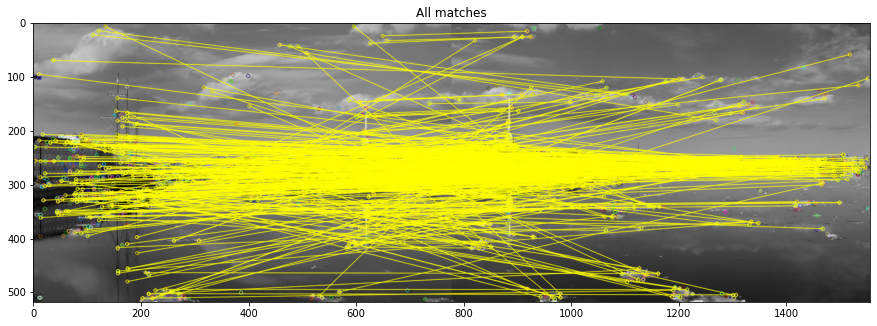

In [ ]:
# creo un immagine con i match di ogni keypoint
result = cv.drawMatches(img1, kps1, img2, kps2, matches, None, 
                        matchColor=[255,255,0])

# visualizzo l'immagine
fig = plt.figure(figsize=[15,10])
plt.imshow(result, cmap='gray')
plt.title("All matches")
plt.show()

<p align='justify'>
Da questa immagine si nota che molti match non sono molto accurati, ad esempio vengono matchati dei punti nel cielo o nell'acqua che sicuramente non possono essere utilizzati per lo stitching, ci sono quindi molti <b> falsi positivi</b>. Provo quindi a visualizzare solo alcuni dei migliori.
</p>

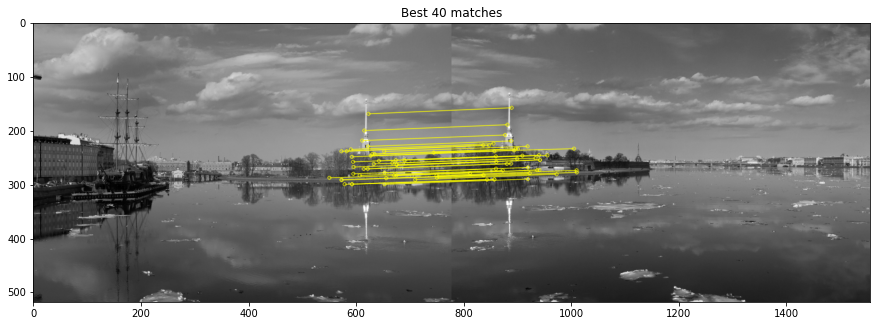

In [ ]:
# Ordino i match in base alla distanza
sort_matches = sorted(matches, key = lambda x:x.distance)

# Visualizzo un immagine con soltanto i primi K match trovati
# con flag = 2 non visualizzo i keypoint non matchati
result = cv.drawMatches(img1, kps1, img2, kps2, sort_matches[:40], None, 
                         matchColor=[255,255,0], flags=2)

fig = plt.figure(figsize=[15,10])
plt.imshow(result)
plt.title("Best 40 matches")
plt.show()

<p align='justify'>
Avendo selezionato soltanto i primi $k$ match il risultato è molto migliore e i match sembrano effettivamente validi. La selezione dei primi $k$ non è però la migliore, nella libreria cv esistono infatti diversi metodi per selezionare solo i match migliori che si basano sulla distanza. <br>
Applico quindi a tutti i match il <b>filtro</b> proposto da <b>Lowe</b> che si basa sul rapporto della distanza per provare ad eliminare i falsi positivi in modo più sensato.

[Reference](https://docs.opencv.org/3.4/d5/d6f/tutorial_feature_flann_matcher.html)
</p>

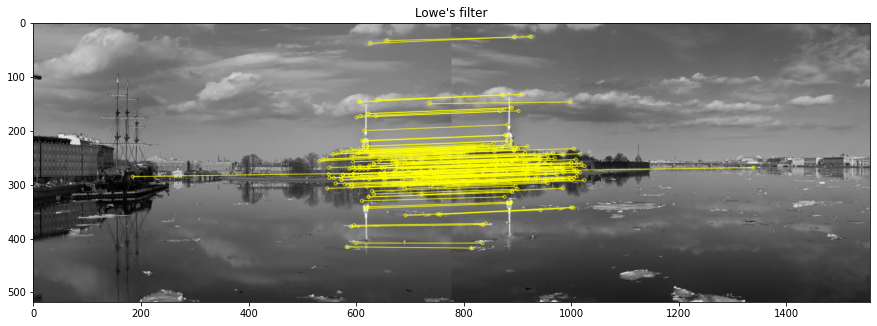

In [ ]:
# massimo rapporto valido per mantenere il match
threshold = 0.6

#Matcho i keypoints con il metodo di FLANN
# Since SURF is a floating-point descriptor NORM_L2 is used
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
knn_matches = matcher.knnMatch(features1, features2, 2)

# Filtro i match usanto il test del rapporto di Lowe
good_matches = []
for m,n in knn_matches:
  if m.distance < threshold * n.distance:
    good_matches.append(m)

# visualizzo i nuovi match trovati
result = cv.drawMatches(img1, kps1, img2, kps2, good_matches, None, 
                         matchColor=[255,255,0], flags=2)

fig = plt.figure(figsize=[15,10])
plt.imshow(result, cmap='gray')
plt.title("Lowe's filter")
plt.show()

<p align='justify'>
Come si può notare il filtro di Lowe è riuscito ad eliminare la maggior parte dei falsi match, in particolare sembra ci sia solo un forte outliers. <br>
Per il resto del notebook utilizzerò quindi i matches estratti con questo filtro.
</p>

In [ ]:
print("Numero di matches validi dopo il filtro di Lowe:", len(good_matches))

Numero di matches validi dopo il filtro di Lowe: 158


## Homografy
<p align='justify'>
Utilizzo la funzione <i>cv.findHomografy()</i> che permette di trovare la trasformazione prospettica di un oggetto dati l'insieme di keypoins trovati in entrambe le immagini. Per farlo ha bisogno di almeno $4$ punti corretti. <br>
Come visto dalla veloce analisi precedente ci possono essere alcuni errori di corrispondenza che potrebbero influenzare il risultato. La funzione restituisce per questo anche una maschera che specifica quali punti sono inlier (stime corrette) e quali outlier.
</p>

In [ ]:
# definisco la funzione che prende in input i keypoint trovati ed i match tra essi
# l'algoritmo richiede almeno 4 match, ma posso specificare anche un numero minimo maggiore

def my_homografy(kps1, kps2, matches, min_match = 4):
  # Se ho abbastanza punti estraggo la posizione dei keypoints da entrambe le immagini
  # utilizzo il metodo .pt che dato un keypoint ne restituisce le coordinate (x,y)
  if len(matches)>min_match:
    # trovo le coordinate di destinazione nella prima immagine
    src_pts = np.float32([kps1[m.queryIdx].pt for m in matches])
    # trovo le coordinate di destinazione nella seconda immagine
    dst_pts = np.float32([kps2[m.trainIdx].pt for m in matches])

    # uso ransac come metodo perchè più robusto e riesce a lavorare anche con outliers
    H, mask = cv.findHomography(dst_pts, src_pts, cv.RANSAC)
    
    # restituisco la matrice H e la maschera in formato lista
    return H, mask.ravel().tolist()

  # se non ci sono abbastanza punti ritorno NULL
  else:
    return null, null

In [ ]:
# applico la funzione di omografia appena definita sui match "buoni"
H, mask = my_homografy(kps1, kps2, good_matches)

# visualizzo il numero di inlier e outlier trovati con la funzione di omografia
print("Numero inlier trovati:",mask.count(1))
print("Numero outlier trovati:",mask.count(0))

Numero inlier trovati: 134
Numero outlier trovati: 24


<p align='justify'>
<b>NOTA:</b> i valori nella matrice H cambiano leggermente da quelli mostrati ad esercitazione perchè sono stati filtrati. Se invece si usano tutti i punti vengono gli stessi valori 
</p>

## Warp
<p align='justify'>
Una volta trovata la matrice H tramite l'omografia è necessario applicare la funzione di warp per poter trasformare geometricamente la seconda immagine e ottenere così l'allineamento corretto con la prima.

In [ ]:
# funzione che date due coordinate estrae le nuove moltiplicandole per la matrice di
# trasposizione
def toworld(x, y, H):
  # aggiungo la terza dimensione per poter effettuare la moltiplication con la matrice H
  # y = scale dei punti, nel caso di partenza è 1
  imagepoint = [x, y, 1]
  # calcolo i nuovi punti moltiplicando le coordinate di partenza per la matrice H
  worldpoint = np.array(np.dot(H,imagepoint))
  # estraggo il fattore scalare
  scalar = worldpoint[2]
  # riscalo i punti opportunamente
  xworld = int((worldpoint[0]/scalar))
  yworld = int((worldpoint[1]/scalar))

  return xworld, yworld

In [ ]:
# definisco la funzione di warp che prende in input l'immagine, la matrice di trasformazione
# ed la nuova dimensione dell'immagine. Nel caso in cui la dimensione non sia definita
# o sia inferiore a quella dell'immagine viene risettata uguale a quella dell'immagine
# in altezza e uguale a due volte la larghezza

def my_warp(img, H, warp_width = 0, warp_heigth = 0):
  # controllo le dimensioni, se una non è definita la calcolo
  # calcolo le coordinate calcolando dove va a finire il pixel in basso a dx dell'immagine
  # se mpltiplicato per la matrice di omografia
  if (warp_heigth < img.shape[0] or warp_width < img.shape[1] or 
      warp_heigth <= 0 or warp_width <= 0):
    # calcolo le nuove dimensioni per l'image di warp
    dwidth, dheight = toworld(img2.shape[1], img2.shape[0], H)

    # se la nuova altezza supera quella di partenza la croppo per evitare di avere
    # un bordo nero inferiore nella nuova immagine (vedi spiegazione in cella di testo sotto)
    if dheight > img2.shape[0]:
      dheight = img2.shape[0]


  # applico la funzione di warp presente in cv, con le dimensioni calcolate (margine di 10 per larghezza)
  return cv.warpPerspective(img, H, dsize=(dwidth-10, dheight))

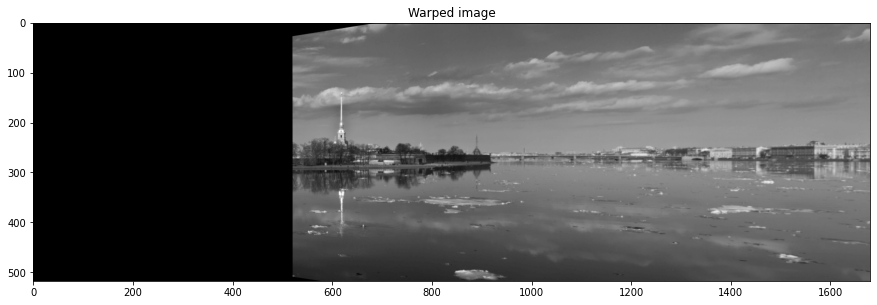

In [ ]:
# applico la funzione di warping
warp_img = my_warp(img2, H)

plt.figure(figsize=(15,5))
plt.imshow(warp_img, cmap='gray')
plt.title("Warped image")
plt.show()

<p align = 'justify'>
Per la scelta della dimensione di warp ho utilizzato il punto nell'angolo in basso a destra dell'immagine di partenza, ho tenuto tuttavia un <i>margine di $10px$ in larghezza </i> per eliminare possibili piccole bande nere in quanto l'immagine non viene posta perfettamente in orizzontale. Lascio inoltre <i>l'altezza invariata</i>, questo perchè altrimenti si avrebbe una banda nera in basso come riportato nella seguente immagine d'esempio.
<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1wk0jL5VkPaeSY3DiXmJzYg-ufZD0a3pA' width=500px>
<figcaption>Wrap con altezze diverse</figcaption>
</center>
</figure>

Ovviamente in questo modo si avrebbe la minor perdita di dati in quanto tutte le porzioni d'immagine vengono mantenute, il risultato ottimale però non è bello da vedere ed è distante da quello che siamo abituati a vedere nelle panoramiche che scattiamo abitualmente.

</p>

## Stitching
<p align='justify'>
Una volta effettuato il warping dell'immagine e quindi aver posizionato la seconda immagine nel giusto punto e con il giusto orientamento posso effettaure lo stitching vero e proprio. In particolare concatenare la prima immagine alla seconda sovrapponendole in modo opportuno, nella sovrapposizione infatti mantengo i valori della prima immagine.
</p>

In [ ]:
# funzione che date due immagini ne esegue il collage concatenandole
# Della seconda img vengono mantenute tutte le righe a partire partendo dalla 
# colonna successiva rispetto alla dim dell'img1

def my_collage(img1, warped_img):
  # codice se si vogliono mantenere dimensioni di warping con altezza diversa
  #img = np.zeros((warped_img.shape[0],img1.shape[1]))
  #img[0:img1.shape[0], 0:img1.shape[1]] = img1

  final_img = np.concatenate((img1,warped_img[:,img1.shape[1]+1:]), axis=1)

  return final_img

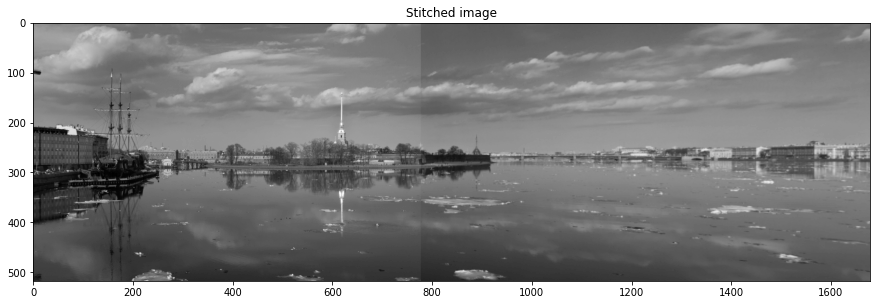

In [ ]:
# concateno la prima immagine con la seconda
stitched_img = my_collage(img1, warp_img)

# visualizzo il risultato dello stitching
plt.figure(figsize=(15,8))
plt.imshow(stitched_img, cmap='gray')
plt.title("Stitched image")
plt.show()

<p align='justify'>
La seconda immagine risulta essere molto più scura, la schiarisco con un metodo molto rudimentale e veloce sommando un valore a tutta la porzione d'immagine.
</p>

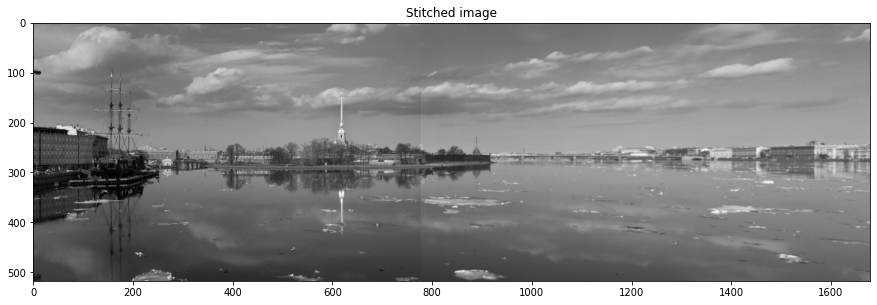

In [ ]:
# schiarsico velocmente tutta l'immagine
stitched_img[:,img1.shape[1]:] = stitched_img[:,img1.shape[1]:] + 6

# visualizzo il risultato dello stitching
plt.figure(figsize=(15,8))
plt.imshow(stitched_img, cmap='gray')
plt.title("Stitched image")
plt.show()

<p align='justify'>
Dal risultato si nota comunque un leggero bordo centrale soprattutto a partire dalla nuvola in giù, si potrebbero applicare dei filtri più appropiati per schiarire. Magari cercando di portare media e deviazione standard del colore di pixel il più simile possibile tra le due immagini.
</p>

## Custom image
<p align='justify'>
Riapplico tutti i passaggi eseguiti con l'immagine di test su altre due immagini personali per verificare il funzionamento dell'algoritmo
</p>

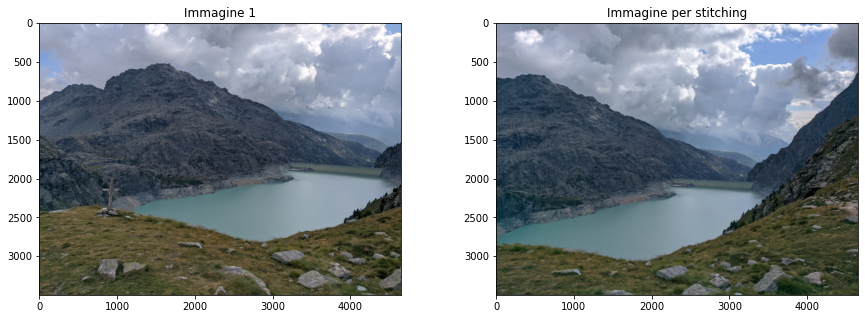

In [ ]:
# Carico e visualizzo le due immagini
# Caricamento immagini
img1 = cv.imread(path + 'mountain1.jpg')[...,::-1]
img2 = cv.imread(path + 'mountain2.jpg')[...,::-1]

# visualizzo le due immagini affiancate
fig = plt.figure(figsize=[15,5])
fig.add_subplot(1,2,1)
plt.imshow(img1)
plt.title('Immagine 1')

fig.add_subplot(1,2,2)
plt.imshow(img2)
plt.title('Immagine per stitching')
plt.show()

In [ ]:
# cerco i keypoint con sift, non serve inizializzarlo uso lo stesso di prima
# estraggo i keypoint dalla prima immagine
kps1, features1 = sift.detectAndCompute(img1, None)
# estraggo i keypoint dalla seconda immagine
kps2, features2 = sift.detectAndCompute(img2, None)

print("Numero di keypoint trovati per la prima immagine:", len(kps1))
print("Numero di keypoint trovati per la seconda immagine:", len(kps2))
print("Numero di descrittori per ogni keypoint:", features1.shape[1])

Numero di keypoint trovati per la prima immagine: 47866
Numero di keypoint trovati per la seconda immagine: 25811
Numero di descrittori per ogni keypoint: 128


In questo caso dato l'alto numero di keypoint non li visualizzo sull'immagine.

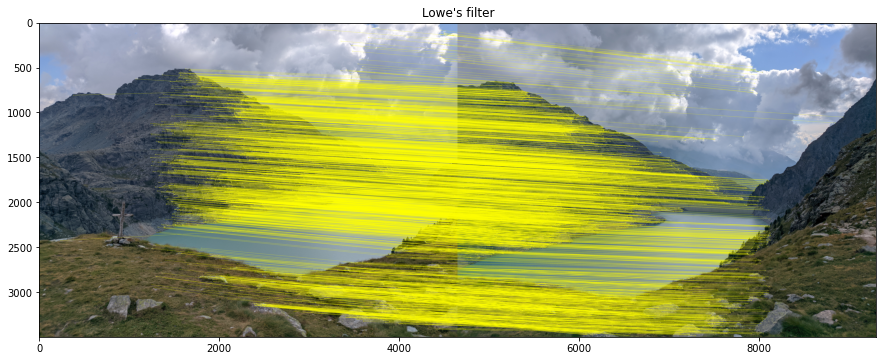

In [ ]:
# applico lo stesso metodo di Lowe per escludere gli outliers

# massimo rapporto valido per mantenere il match
threshold = 0.6

# Matcho i keypoints con il metodo di FLANN
# Since SURF is a floating-point descriptor NORM_L2 is used
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
knn_matches = matcher.knnMatch(features1, features2, 2)

# Filtro i match usanto il test del rapporto di Lowe
good_matches = []
for m,n in knn_matches:
  if m.distance < threshold * n.distance:
    good_matches.append(m)

# visualizzo i nuovi match trovati
result = cv.drawMatches(img1, kps1, img2, kps2, good_matches, None, 
                         matchColor=[255,255,0], flags=2)

fig = plt.figure(figsize=[15,10])
plt.imshow(result, cmap='gray')
plt.title("Lowe's filter")
plt.show()

In [ ]:
# visualizzo alcune informazioni utili
print('Numero di matches trovati:', len(good_matches))

Numero di matches trovati: 3035


In [ ]:
# applico l'homografy

# applico la funzione di omografia appena definita sui match "buoni"
H, mask = my_homografy(kps1, kps2, good_matches)

# visualizzo il numero di inlier e outlier trovati con la funzione di omografia
print("Numero inlier trovati:",mask.count(1))
print("Numero outlier trovati:",mask.count(0))

Numero inlier trovati: 1936
Numero outlier trovati: 1099


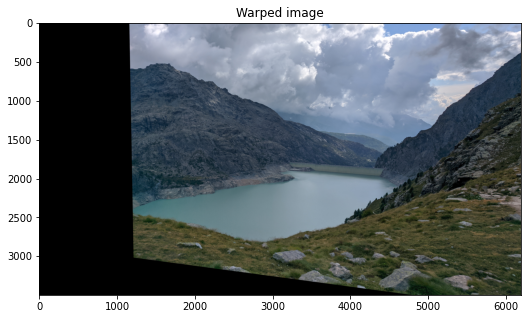

In [ ]:
# applico la funzione di warp lasciando calcolare in automatico la nuova dimensione
warp_img = my_warp(img2, H)


plt.figure(figsize=(15,5))
plt.imshow(warp_img, cmap='gray')
plt.title("Warped image")
plt.show()

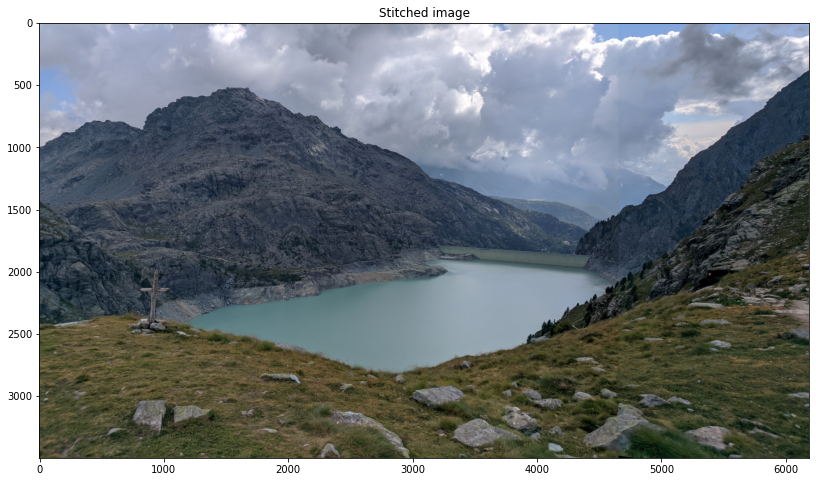

In [ ]:
# visualizzo le immagini stitchate
# concateno la prima immagine con la seconda
stitched_img = my_collage(img1, warp_img)

# visualizzo il risultato dello stitching
plt.figure(figsize=(15,8))
plt.imshow(stitched_img, cmap='gray')
plt.title("Stitched image")
plt.show()

<p align='justify'>
In questo caso la seconda immagine risulta essere leggermente più chiara della prima, ma non in tutti i punti. La differenza si nota soprattutto nel prato e nella montagna, tuttavia ci sono dei punti completamente bianchi (nuvole) o altri molto tendenti al nero nella parte della montagna. Per questo motivo la semplice somma di uno scalare non è ideale perchè brucerebbe una delle due parti. In questo caso andrebbero attuati miglioramenti più specifici per avere la stessa luminosità.
</p>

In [ ]:
# download notebook in .html extension
%%shell
jupyter nbconvert --to html '/content/gdrive/MyDrive/Colab Notebooks/DigitalSignal/Assignment/Assignment3/DSIM_Assignment3.ipynb'

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/Colab Notebooks/DigitalSignal/Assignment/Assignment3/DSIM_Assignment3.ipynb to html
[NbConvertApp] Writing 4503758 bytes to /content/gdrive/MyDrive/Colab Notebooks/DigitalSignal/Assignment/Assignment3/DSIM_Assignment3.html
